# Serving your model exercise. Part 1 - Flask

**created by:** Nir Barazida

**project:** email classifier application deployed on on-line server

# notes to the checker !!!

Dear checker,

In this exercise, I have implemented a flask app with user interface.

features:

- User registration to the application (saved in SQLite database)
- Classifier for emails - spam or ham, pickled and deployed. only users can use  the classifier (canceled this feature to use request - can't connect as a user using requests - opened a help request on hive)
- stores all the classified email per user in the database and show it on the classifier page.
- Classifier using param or json file.
- deployed the app on a [remote server](http://172.104.139.73/) - having troubles with Nginx - opened a help request on hive.
- To run the app - please run main and please go to your localhost at port 5000 to see the user interface.
- created a [git repository](https://github.com/nirbarazida/Email_classifier) with the project.

It's the first time using this technology (flask and deploy the app on server) - would very appreciate getting notes from you about **everything** - project architecture, functions, coding, readme - **every word** will be appreciated 

### p.s.
Used my own python packege in this Exercise - just `pip install NBprocessing` to use it

Thanks,

Nir Barazida

In [ ]:
!pip install NBprocessing

## Intro
Reminder, there will usually be 3 different places where the code relevant to our model prediction runs:
1. **Training computer / server** - where we train our model and save it
2. **Inference server** - server that listens to REST API requests to make predictions / inferences with the model that was trained on the model server. Potentially, we could have many such servers. 
3. **Client** - client application (browser, mobile app etc.) that needs a prediction, and requests from **inference server** over HTTP with REST API to make the prediction

In [144]:
import pandas as pd
from NBprocessing import NBgeneral, NBplot, NBcategorical
from sklearn.feature_extraction.text import CountVectorizer
import string

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import pickle

## 1. Getting to a trained model
- Choose one of the models you trained in one the previous exercises or any other model. **Do not take something from many Flask examples online!**
- Specify where can one download the dataset from (to be used during checking the exercise)
- Say in one word what is the business problem and what you are predicting 
- Preprocess, split to train and test dataset
- Train the model - the exact accuracy is not of big importance here
- Do a few predictions of the model locally

This code will run on the **training server**

#### The dataset:

In this exercise I will use the enron dataset that can be found on our [Google drive](https://drive.google.com/drive/folders/1mK-Au2ScIxG1_OMfKfY3Q7VzgkAf-uWx).\
I will use this data to train a spam filter, using a processed version of the Enron dataset including labels for "ham" (non-spam) and spam emails, provided by the [NLP group at the Athens University of Economics and Business](http://nlp.cs.aueb.gr/software.html) (AUEB).\
I this case I will use the AUEB predictions as the true label of the data and will try to classify the data for ham or spam myself.\
I will also zip the csv file to this solution.

#### business problem:

Classify emails as ham or sapm

#### Preprocess, split to train and test dataset

In [145]:
# load the dataset
data = pd.read_csv('enron.csv')

In [146]:
data.shape

(38891, 3)

In [147]:
data.columns

Index(['filename', 'label', 'text'], dtype='object')

In [148]:
data.sample(2)

,filename,label,text
26844,enron5/spam/1042.2002-08-25.SA_and_HP.spam.txt,spam,Subject: better sex for $ 2 . 99 until 08 / 26...
4145,enron6/ham/4984.2001-11-14.lokay.ham.txt,ham,"Subject: fw :\nanother mention\nthen , at an a..."


In [8]:
data[data['label']=='ham'].head(2)

,filename,label,text
0,enron1/ham/1061.2000-05-10.farmer.ham.txt,ham,Subject: ena sales on hpl\njust to update you ...
1,enron1/ham/0446.2000-02-18.farmer.ham.txt,ham,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...


In [9]:
data[data['label']=='spam'].head(2)

,filename,label,text
18045,enron1/spam/4743.2005-06-25.GP.spam.txt,spam,"Subject: what up , , your cam babe\nwhat are y..."
18046,enron1/spam/1309.2004-06-08.GP.spam.txt,spam,Subject: want to make more money ?\norder conf...


In [10]:
NBcategorical.category_ratio(data,['label'],2)

,0,1
label,spam : 53.6%,ham : 46.4%


In [11]:
data['text'][0]

"Subject: ena sales on hpl\njust to update you on this project ' s status :\nbased on a new report that scott mills ran for me from sitara , i have come up\nwith the following counterparties as the ones to which ena is selling gas off\nof hpl ' s pipe .\naltrade transaction , l . l . c . gulf gas utilities company\nbrazoria , city of panther pipeline , inc .\ncentral illinois light company praxair , inc .\ncentral power and light company reliant energy - entex\nces - equistar chemicals , lp reliant energy - hl & p\ncorpus christi gas marketing , lp southern union company\nd & h gas company , inc . texas utilities fuel company\nduke energy field services , inc . txu gas distribution\nentex gas marketing company union carbide corporation\nequistar chemicals , lp unit gas transmission company inc .\nsince i ' m not sure exactly what gets entered into sitara , pat clynes\nsuggested that i check with daren farmer to make sure that i ' m not missing\nsomething ( which i did below ) . while i

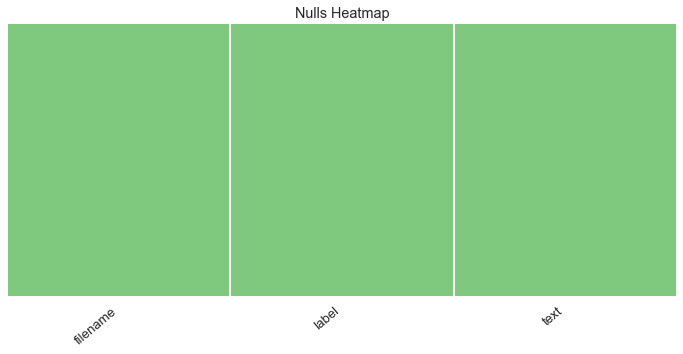

In [12]:
NBplot.plot_missing_value_heatmap(data)

In [13]:
NBgeneral.missing_values(data)

,#Missing_values,%Missing_values


#### Insights

- We can tell that the data is balanced - almost split into half for ham and sapm.
- ~39K of indexes is a far share of data - can create a reliable model
- we have no missing values in the dataset
- The text has:
    - a lot of punctuation and '\n'
    - lower and upper case letters
    - unexpected numbers and letters - probably bad encoding of the text format

In [14]:
# change the label to numeric
y = data['label'].map({'ham':0, 'spam':1})
y.value_counts()

1    20846
0    18045
Name: label, dtype: int64

In [15]:
y.shape

(38891,)

Convert the text of emails to a feature matrix X whose rows are "bag of words" feature vectors.

In [16]:
#lets first 'claen' the text indexes
clean_text = data['text'].map(lambda x: x.lower().replace('\n', '').translate(str.maketrans('', '', string.punctuation)))

In [17]:
# create 500 vectores of words. each vector is a combination of 1-2 words
email_text_list = clean_text.tolist()
vectorizer = CountVectorizer( encoding='utf-8', decode_error='ignore',stop_words = 'english',
                             analyzer='word', ngram_range=(1, 2),max_features=500)
X = vectorizer.fit_transform(email_text_list)
print(vectorizer.get_feature_names()[0:100])

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2000', '2001', '2002', '2004', '2005', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '40', '45', '50', '500', '60', '70', '713', '75', '80', '90', '95', '97', '99', 'able', 'access', 'account', 'act', 'action', 'additional', 'address', 'adobe', 'advice', 'agreement', 'alias', 'america', 'amto', 'analyst', 'approved', 'april', 'assets', 'attached', 'august', 'available', 'bank', 'based', 'believe', 'best', 'better', 'big', 'billion', 'board', 'book', 'business', 'buy', 'california', 'capacity', 'capital', 'case', 'cash', 'cc', 'center', 'ceo', 'chairman', 'change', 'changes', 'check', 'chief', 'click', 'close', 'com', 'come']


In [18]:
X.shape

(38891, 500)

In [19]:
# convert X (Count Vectorizer object) to a data frame with labels name
X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
X.sample(2)

,00,000,01,02,03,04,05,06,07,08,...,weeks,wish,work,working,works,world,www,year,years,york
30360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now each row represent how many times the vector appears in the text.

In [20]:
# check datasets dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (38891, 500)
y shape: (38891,)


In [21]:
# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=42)

### create the model

I will  use a random  forest calssifier and to correctly choose the Hyper parameters I will use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) tool - Exhaustive search over specified parameter values for an estimator.

class sklearn.ensemble.RandomForestClassifier(`n_estimators=100`, *, criterion='gini', `max_depth=None`, `min_samples_split=2`, `min_samples_leaf=1`, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None

`n_estimators` - The number of trees in the forest.\
`max_depth` - The maximum depth of the tree.\
`min_samples_split` - The minimum number of samples required to split an internal node.\
`min_samples_leaf` - The minimum number of samples required to be at a leaf node. 

In [20]:
max_depth = [10,20]
min_samples_split = [1,2]
min_samples_leaf = [2,4]
n_estimators = [100,150,200]
param_grid_rf = {'n_estimators':n_estimators,
              'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf}
param_grid_rf

{'n_estimators': [100, 150, 200],
 'max_depth': [10, 20],
 'min_samples_split': [1, 2],
 'min_samples_leaf': [2, 4]}

In [21]:
clf_grid_rf = GridSearchCV(RandomForestClassifier(),
                             param_grid=param_grid_rf,
                             cv=3, verbose=2, n_jobs=3)

In [22]:
clf_grid_rf.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:  7.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=3,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [1, 2],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [43]:
clf_grid_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [23]:
clf_rf = RandomForestClassifier(**clf_grid_rf.best_params_)
clf_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=150)

In [24]:
y_pred = clf_rf.predict(X_test)

In [25]:
print(f"Classification report for Random Forest Classifier:\n\n")
print(classification_report(y_test,y_pred))

Classification report for Random Forest Classifier:


              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3590
           1       0.90      0.99      0.94      4189

    accuracy                           0.94      7779
   macro avg       0.95      0.93      0.94      7779
weighted avg       0.94      0.94      0.94      7779



The model score is not that good, let's try with different parameters

In [22]:
n_estimators = [100,150,200]
param_grid_rf = {'n_estimators':n_estimators}
param_grid_rf

{'n_estimators': [100, 150, 200]}

In [25]:
clf_grid_rf_2 = GridSearchCV(RandomForestClassifier(),
                             param_grid=param_grid_rf,
                             cv=3, verbose=2, n_jobs=3)
clf_grid_rf_2.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:  4.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=3,
             param_grid={'n_estimators': [100, 150, 200]}, verbose=2)

In [149]:
clf_grid_rf_2.best_params_

{'n_estimators': 150}

In [150]:
clf_rf_2 = RandomForestClassifier(**clf_grid_rf_2.best_params_)
clf_rf_2.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150)

In [151]:
y_pred_2 = clf_rf_2.predict(X_test)

In [152]:
print(f"Classification report for Random Forest Classifier:\n\n")
print(classification_report(y_test,y_pred_2))

Classification report for Random Forest Classifier:


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3590
           1       0.97      0.99      0.98      4189

    accuracy                           0.97      7779
   macro avg       0.97      0.97      0.97      7779
weighted avg       0.97      0.97      0.97      7779



In this business problem we are predicting if a email is sapm or not.\
As a company that provides email services we would like to make sure that **all** real emails will go to the in-box, even in case of sapm leakage to the the in-box\
Thus, we wolud like to max the recall (min the FN).\
From the classification report we can tell that the recall score is very high - the model works fine.

## 2. Save you model, predict with saved model

Simulate in this notebook code that will happen during training on the **training server**:
- Using `pickle`, save your model to disk. Reference: https://scikit-learn.org/stable/modules/model_persistence.html
- Save the test dataset to file.  What's a good format(s) for saving datasets?

In [153]:
filename = 'vectorizer_model_for_SOH.pkl'
pickle.dump(vectorizer, open(filename, 'wb'))

In [154]:
# save the model to disk
filename = 'rfc_model_for_SOH.pkl'
pickle.dump(clf_rf_2, open(filename, 'wb'))

In [155]:
# lets check that it worked
loaded_model = pickle.load(open(filename, 'rb'))
y_pred_2 = loaded_model.predict(X_test)
print(f"Classification report for Random Forest Classifier from pickle file:\n\n")
print(classification_report(y_test,y_pred_2))

Classification report for Random Forest Classifier from pickle file:


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3590
           1       0.97      0.99      0.98      4189

    accuracy                           0.97      7779
   macro avg       0.97      0.97      0.97      7779
weighted avg       0.97      0.97      0.97      7779



### great !
We can see that we've got the same results as the original model (some minor changes, because of the score rounding) .\
What happened is that `pickle` encoded our model and saved it as a pickle object. Now the model is saved on my local disk and can be used, after unpacking it, again and not create, parametrize and train another model.\
wow - that can save some time!

Simulate in this notebook code that will happen during inference on the **inference server**:
- Load the model again with `pickle`.
- Read the test dataset file, and perform some predictions
- Compare the predictions received before saving the model, and after reading a saved model.  Show that you get the same results. 

Answered it in the above (:

## 3. Serve your model

Now we are done with **training server**, since we have the saved model.  From now all that's relevant is **inference server** and **client** code.

Let's create the **inference server** that answers to REST APIs with predictions:

- Using `flask`, create a Pycharm project and implement the following prediction API:
- **Single prediction API** that receives inputs as parameters (no body), and returns a single prediction as a string / text.  
- Example: http://localhost:5000/predict_single?key1=value1&key2=value2 (replace `key1`, `value1` etc. names with your relevant feature names and values)
- Consider what's the best place in your code to put the code that reads from the model.  Why?
- In general, take runtime efficiency into account.  Your API might be called large number of times per second, and you will be paying for more inference servers if your code is not efficient.
- Copy your **inference server** code also here for reference

# It doesn't work. can't connect to the API as user - need your help here

In [47]:
import requests

payload = {
    'username': 'admin',
    'password': '123456'
}

with requests.Session() as s:
    p = s.post('http://127.0.0.1:5000', params=payload)
    # print the html returned or something more intelligent to see if it's a successful login page.
    print (p.text)


<!DOCTYPE html>
<html>
<head>
    <!-- Required meta tags -->
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">

    <!-- Bootstrap CSS -->
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">

    <link rel="stylesheet" type="text/css" href="/static/main.css">

    <!-- Name on the toolbar-->
    
        <title>Spam or Ham</title>
    
</head>
<body>
    <header class="site-header">
      <nav class="navbar navbar-expand-md navbar-dark bg-steel fixed-top">
        <div class="container">
          <a class="navbar-brand mr-4" href="/home">Spam or Ham</a>
          <button class="navbar-toggler" type="button" data-toggle="collapse" data-target="#navbarToggle" aria-controls="navbarToggle" aria-expanded="false" aria-label="Toggle navigation">
            <span c

In [156]:
content = {"content":"This is spam! blah blah blah"}

In [157]:
with requests.Session() as s:
    pred = s.get('http://127.0.0.1:5000/classifier', params=content).text
    print(pred)

Spam


## 4. Consume your model with python

Use Python `requests` module from here to make a prediction.  **Print input and output of the prediction.**

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

did it in the above question

## 5. Using JSON files

- Using `flask`, add code to your previous file in Pycharm **with inference code** to create the following prediction API (in addition to **Single prediction API** done above):
- **Multiple prediction API** that receives input many observations to predict on as a json file in the body, and returns a json file with predictions.
- Your **JSON** file format has to be efficient, clear and following JSON file syntax: 
  - JSON file is a nested structure of potentially multiple dictionaries and lists 
  - JSON file tip: Use lists, every member in the list can be a dictionary of all the features.  
  - JSON file tip: Do not put indexes of predictions into the JSON files, indexes of predictions can be easily computed with Python code later 
  - JSON files are sometimes slightly verbose, but are extremely human readable.  Just looking at your JSON files of input and output, is it possible to understand what were the observations in input and what were the predictions in output?
  - See https://www.json.org/json-en.html for JSON format
- Think about efficiency of your code - your REST API might be called a huge number of times, with a huge number of observations every time.  Can part of the code be done only once?  Can you predict on everything together? Can you do less or cheaper data conversions?
- Example of URL that will be used to predict: http://localhost:5000/predict
- Reference for working with JSONs in Flask: https://pythonise.com/series/learning-flask/working-with-json-in-flask
- Do you need a GET or a POST type of REST API call? Does it change what you did in step 3?  Conceptually, would you say it makes sense to use GET or POST types for predictions?
- Copy your **inference server** code also here for reference 

In [158]:
param = {"email1":{"content":"""
                                It looks like you've deployed your first Linode! Congrats!
                                Since you've officially kicked off your journey,
                                we wanted to check in and make sure you know about all of the tools and products that are now at your fingertips. Whether you're just here for the compute,
                                or you've got plans to build the most sophisticated cloud platform known to humankind, it's important that you know what sort of capabilities are available to 
                               """
                   },
         "email2":{"content":"""
                            Next week's lectures:
                            Sunday - HMM with Danielle
                            -Markov Chains
                            -Hidden Markov Models - motivation and applications
                            -Dynamic Programming
                            -Viterbi, Forward-backward, and Baum-Welch Algorithms
                            -Using HMMs in Python

                            Monday - CNN with Mike (guest lecturer)
                            -CNN architecture overview
                            -Convolution
                            -Typical CNN layers
                            -CNN advantages
                            -CNN applications
                            Intro to Hackathon and inspiration from Netafim

                            Tuesday - Optimizers with Morris
                            -Gradient descent - review
                            -Stochastic gradient descent (SGD)
                            -Mini-batches and batch size
                            -Adaptive learning rate methods: Momentum, RMSProp and Adam
                            -Bonus: cyclical learning rates
                            Hackathon Inspiration Panel - Aleph Farms

                            Wednesday - RNN with Morris
                            -Motivation
                            -Simple RNNs
                            -LSTMs and GRUs
                            -RNN syntax in Tensorflow

                            Thursday - Monitoring NNs and with Morris
                            -Saving and loading models: SavedModel and checkpoint formats
                            -Monitoring metrics
                            -Tensorflow callbacks: EarlyStopping, ModelCheckpoint, and TensorBoard
                            -Hyperparameter optimization
                            Intro to CV/NLP with Morris
                            -Why we teach tracks: deep learning and “hard problems”
                            -Examples of NLP tasks
                            -Examples of CV tasks
                            -How to stay up to date with the start-of-the-art
                            Hackathon Inspiration Panel - Tal-Ya Agriculture Solutions
                             """
                 },
         "email3":{"content":"""
                            Hi Nir,

                            Today we conducted the 1st checkpoint of the Fellows program.

                            The program staff evaluated each of you at the checkpoint according to the following criteria:
                            Exam grade
                            Saf exercises (% of submissions and the quality of the assignments).
                            Project
                            Mentor and lecturers feedback
                            Attitude and behavior
                            General comments
                            Congratulations! You officially passed the 1st CP of the program.
                            If any critical points came up regarding the discussion about you, to preserve or improve, the program staff will contact you to talk about it. We will try to speak with you all in the upcoming week.
                            Keep up the good work!
                            Chay and the Fellows staff
                             """
                 }
        
        }

In [161]:
import json
JSON_FILE_NAME = 'emails_input.json'

with open(JSON_FILE_NAME, 'w') as outfile:
    json.dump(param, outfile, indent=2)
    
with open(JSON_FILE_NAME, "r") as json_file:
    emails_to_pred = json.load(json_file)

In [160]:
with requests.Session() as s:
    pred = s.get('http://127.0.0.1:5000/classifier', json=emails_to_pred)
    print(pred.text)

{
  "email1": {
    "content": "\n                                It looks like you've deployed your first Linode! Congrats!\n                                Since you've officially kicked off your journey,\n                                we wanted to check in and make sure you know about all of the tools and products that are now at your fingertips. Whether you're just here for the compute,\n                                or you've got plans to build the most sophisticated cloud platform known to humankind, it's important that you know what sort of capabilities are available to \n                               ", 
    "label": "Spam"
  }, 
  "email2": {
    "content": "\n                            Next week's lectures:\n                            Sunday - HMM with Danielle\n                            -Markov Chains\n                            -Hidden Markov Models - motivation and applications\n                            -Dynamic Programming\n                            -Viterb

Use Python `requests` module from here to make a prediction, and **print the input, and the output** of the prediction (or part of it if it's too large).  

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

did it in the question above

## 6. Submit a zip file with:
1. This notebook
2. Your Python inference server file